In [1]:
import pickle
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy import stats

In [2]:
#experiment,lmt = ['Arabidopsis_GenomeWide_Analysis_euclidean_v8_fixed',0.2]
experiment,lmt = ['Human_Promoter_Analysis_euclidean_v8',0.08]
#experiment,lmt = ['TAL-GATA_binaryFeat_Analysis_allTFs_euclidean_v8_from_customTFs',0.08]

In [3]:
with open(f'../Results/{experiment}/Interactions_SATORI/main_results_raw.pckl','rb') as f:
    attentions, positions, seqposes = pickle.load(f)
with open(f'../Results/{experiment}/Interactions_SATORI/interaction_keys_dict.pckl', 'rb') as f:
    intr_keys = pickle.load(f)
df_intr = pd.read_csv(f'../Results/{experiment}/Interactions_SATORI/interactions_summary_attnLimit-{lmt}.txt',sep='\t')
filter_ICs = pd.read_csv(f'../Results/{experiment}/Motif_Analysis/table.txt')

In [4]:
df_intr = df_intr[df_intr['adjusted_pval']<0.05].reset_index(drop=True)

In [5]:
df_intr.shape

(843, 12)

In [6]:
raw_col = filter_ICs.columns[0]
cols = ['filter#'] + raw_col.split()
data = filter_ICs[raw_col].apply(lambda x: x.split()).tolist()
filter_ICs = pd.DataFrame(data, columns=cols)
filter_ICs['filter'] = filter_ICs['filter#'].apply(lambda x: f"filter{x}")

In [7]:
filter_ICs.head()

,filter#,consensus,annotation,ic,mean,std,filter
0,0,AGAGTGGAATTTG,SOX3,2.97,0.3439,0.5420,filter0
1,1,CAGCTCTCTAAAT,TLX2,4.56,0.3444,0.5333,filter1
2,2,TATAATAAGTTCG,SOX1,4.31,0.3170,0.5241,filter2
3,3,CCCCTATAGAAGG,.,3.15,0.3731,0.5545,filter3
4,4,CTCCGTAAACGAC,.,4.68,0.3378,0.5275,filter4


In [ ]:
# get_attn_values_function()
attn_mat = np.asarray([attn_mat[:,feat_size*i:feat_size*(i+1)] for i in range(0,params['num_multiheads'])]) 
attn_mat = np.max(attn_mat, axis=0) #out of the 8 attn matrices, get the max value at the corresponding positions

for i in range(0, attn_mat.shape[0]):
    if i not in seq_inf_dict:
        continue
    for j in range(0, attn_mat.shape[1]):
        if j not in seq_inf_dict:
            continue
        if i==j:
            continue
        max_loc = [i,j]#attn_mat[i,j]

        pos_diff = CNNfirstpool * abs(max_loc[0]-max_loc[1])

        KeyA = i #seq_inf_dict already is for the current header and we just need to specify the Pooled position
        KeyB = j 

        attn_val = attn_mat[i,j]

        all_filters_posA = seq_inf_dict[KeyA]
        all_filters_posB = seq_inf_dict[KeyB]

##### Pseud-code/logic
For batch in seqposes:
    attn_matrices_batch = read attention matrices for the given batch using arg(batch)
    for seq_inf_dict,attn_matrix in zip(batch,attn_matrices_batch):
        query_filter_attn_val_matrix = get_attn_values_function(seq_inf_dict, attn_matrix)

Once we have attn values for each query filter, use the analysis to generate a scatter plot using query filter IC values vs. the corresponding non-zero attention scores.

In [205]:
attns = []
for row in attentions:
    attns.append(row[row!=-1].mean())
attns = np.asarray(attns)

In [206]:
attns.shape

(19900,)

In [207]:
x = []
y = []
for key,index in intr_keys.items():
    filter1,filter2 = key.split('<-->')
    IC_filter1 = filter_ICs[filter_ICs['filter']==filter1]['ic']
    IC_filter2 = filter_ICs[filter_ICs['filter']==filter2]['ic']
    IC_sum = float(IC_filter1) + float(IC_filter2)
    x.append(IC_sum)
    y.append(attns[index])

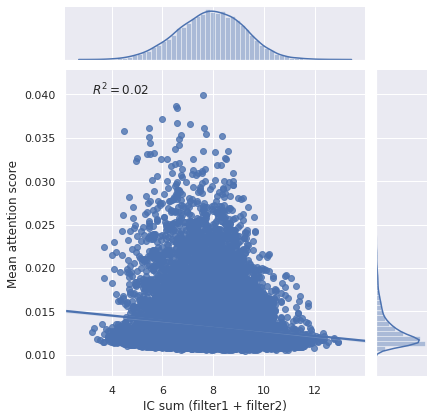

In [208]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

res = pd.DataFrame([x,y]).T
res.columns = ['IC sum', 'Mean attention score']
sns.jointplot(res['IC sum'], res['Mean attention score'], kind="reg")
r2val = r2(res['IC sum'], res['Mean attention score'])
plt.text(min(x),max(y),r'$R^2=$'+str(round(r2val,2)))
plt.xlabel('IC sum (filter1 + filter2)')
plt.show()

### For Simulated Data

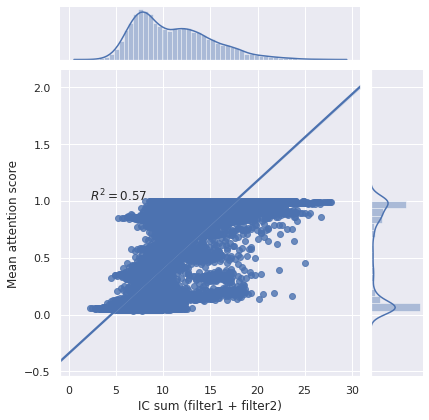

In [197]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

res = pd.DataFrame([x,y]).T
res.columns = ['IC sum', 'Mean attention score']
sns.jointplot(res['IC sum'], res['Mean attention score'], kind="reg")
r2val = r2(res['IC sum'], res['Mean attention score'])
plt.text(min(x),max(y),r'$R^2=$'+str(round(r2val,2)))
plt.xlabel('IC sum (filter1 + filter2)')
plt.show()